In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SSB

SSB er bra.

In [111]:
import requests
from pyjstat import pyjstat

```console
pip install pyjstat
```

En funksjon jeg fant et sted en gang...

In [109]:
def apiToDataframe(postUrl, query):

	# postUrl som spørringen skal postes mot
	# Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

	res = requests.post(postUrl, json=query)
	# legger resultat i ds. DS har i tillegg en del metadata
	ds = pyjstat.Dataset.read(res.text)
	# skriver resultatet til to dataframes
    # først dataframe med tekst
	df = ds.write('dataframe')
    # deretter dataframe med koder
	df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
	return df, df_id, ds

In [112]:
# KPI
df1, df_id, ds = apiToDataframe('https://data.ssb.no/api/v0/no/table/03013/', {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "vs:CoiCop2016niva1",
        "values": []
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KpiIndMnd"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
})
df1['date'] = pd.to_datetime(df1['måned'], format='%YM%m')
#df1['value'] = df1['value']/df1['value'].shift(12) - 1 # yoy
df1 = df1[['value', 'date']]
df1 = df1.rename(columns={'value':'kpi'})

In [113]:
# ledightesrate
df2, df_id, ds = apiToDataframe('https://data.ssb.no/api/v0/no/table/13760/', {
  "query": [
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Justering",
      "selection": {
        "filter": "item",
        "values": [
          "IS"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "ArbledProsArbstyrk"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
})
df2['date'] = pd.to_datetime(df2['måned'], format='%YM%m')
df2 = df2[['value', 'date']]
df2['value'] = df2['value']/100
df2 = df2.rename(columns={'value':'ledighet'})

In [121]:
df = pd.merge(df1,df2, on='date').set_index('date').dropna()
df['kpi_yoy'] = df['kpi']/df['kpi'].shift(12) - 1
df = df.drop('kpi', axis=1)
df = df.dropna()
df

,ledighet,kpi_yoy
date,,
2007-01-01,0.030,0.012092
2007-02-01,0.028,0.007194
2007-03-01,0.029,0.010766
2007-04-01,0.029,0.002372
2007-05-01,0.029,0.003559
...,...,...
2023-03-01,0.038,0.065109
2023-04-01,0.035,0.064356
2023-05-01,0.032,0.066667


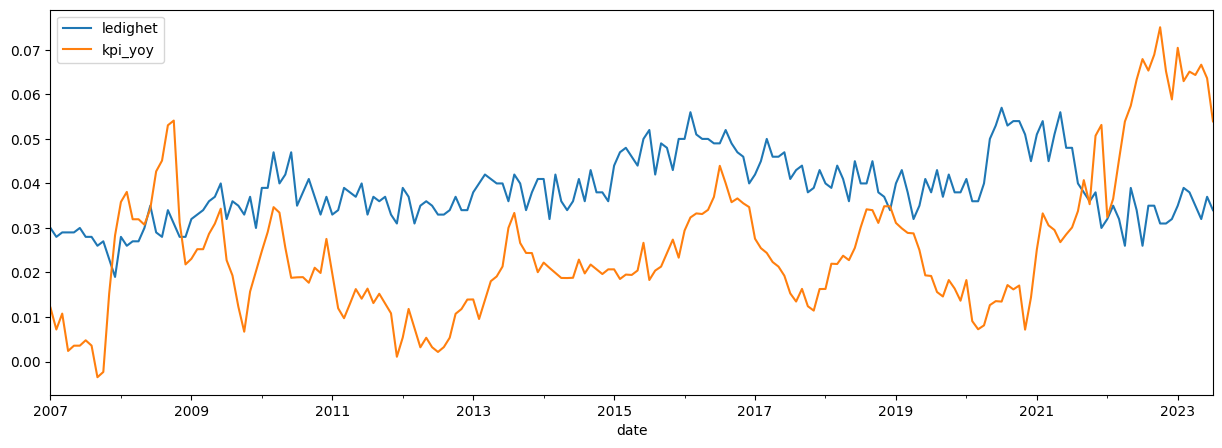

In [123]:
df.plot(figsize=(15,5))
plt.show()

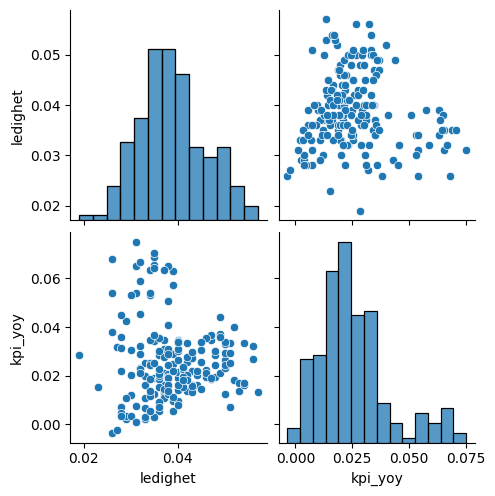

In [125]:
sns.pairplot(df)
plt.show()

# FRED

```console
pip install fredapi
```



docs: https://pypi.org/project/fredapi/

Er bra når du trenger lange tidsserier. Vær oppmerksom på at mye av dataen kun rapporteres per kvartal. De rapporterer data for hele verden sånn ca.

In [6]:
from fredapi import Fred


In [7]:
import fredkey
fred = Fred(api_key=fredkey.key) # Jeg skuler min nøkkel her. Skaff din egen.

In [33]:
unem = fred.get_series('LMUNRRTTNOM156S')/100
cpi = fred.get_series('NORCPIALLMINMEI')
interest = fred.get_series('IR3TIB01NOM156N') 
debt = fred.get_series('TDSAMRIAONCNO') 
gdp = fred.get_series('CLVMNACSCAB1GQNO')
eu_cpi = fred.get_series('ELGAS0EUCCM086NEST')

df = pd.concat([cpi,unem, interest, debt, gdp, eu_cpi], axis=1)
df = df.rename(columns={0:'cpi',1:'unem', 2:'interest', 3:'debt', 4:'gdp', 5:'eu_cpi'})
df = df.dropna()

shift = 4
df['cpi_yoy'] = df['cpi']/df['cpi'].shift(shift) - 1
df['unem_yoy'] = df['unem']/df['unem'].shift(shift) - 1
df['interest_yoy'] = df['interest']/df['interest'].shift(shift) - 1
df['debt_yoy'] = df['debt']/df['debt'].shift(shift) - 1
df['gdp_yoy'] = df['gdp']/df['gdp'].shift(shift) - 1
df['eu_cpi_yoy'] = df['eu_cpi']/df['eu_cpi'].shift(shift) - 1
df = df.dropna()
df

,cpi,unem,interest,debt,gdp,eu_cpi,cpi_yoy,unem_yoy,interest_yoy,debt_yoy,gdp_yoy,eu_cpi_yoy
1997-01-01,69.3,0.036587,3.52,15313.0,504637.6,52.15,0.029718,-0.150006,-0.357664,0.115376,0.042792,0.014394
1997-04-01,69.7,0.035082,3.50,15015.0,516873.2,52.37,0.026510,-0.190116,-0.255319,0.079517,0.069550,0.017881
1997-07-01,69.9,0.032850,4.00,16803.0,516314.0,52.36,0.023426,-0.229120,-0.198397,0.173312,0.033762,0.021061
1997-10-01,70.3,0.030072,3.97,15645.0,523645.3,52.32,0.020319,-0.223973,-0.212302,0.041473,0.065621,0.016120
1998-01-01,70.7,0.026420,3.82,15359.0,528719.3,52.36,0.020202,-0.277870,0.085227,0.003004,0.047721,0.004027
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,117.2,0.024543,0.74,98268.0,790881.9,119.64,0.035336,-0.366384,1.242424,-0.007885,0.046779,0.155607
2022-01-01,117.8,0.022944,1.10,98582.0,786350.7,136.80,0.032428,-0.410025,1.291667,-0.009256,0.044347,0.278146
2022-04-01,121.2,0.017952,1.27,93492.0,795518.1,146.37,0.053913,-0.526528,3.233333,-0.083160,0.043147,0.355152
2022-07-01,124.2,0.016841,2.24,89528.0,805385.1,154.32,0.067928,-0.456888,6.000000,-0.116671,0.022895,0.392026


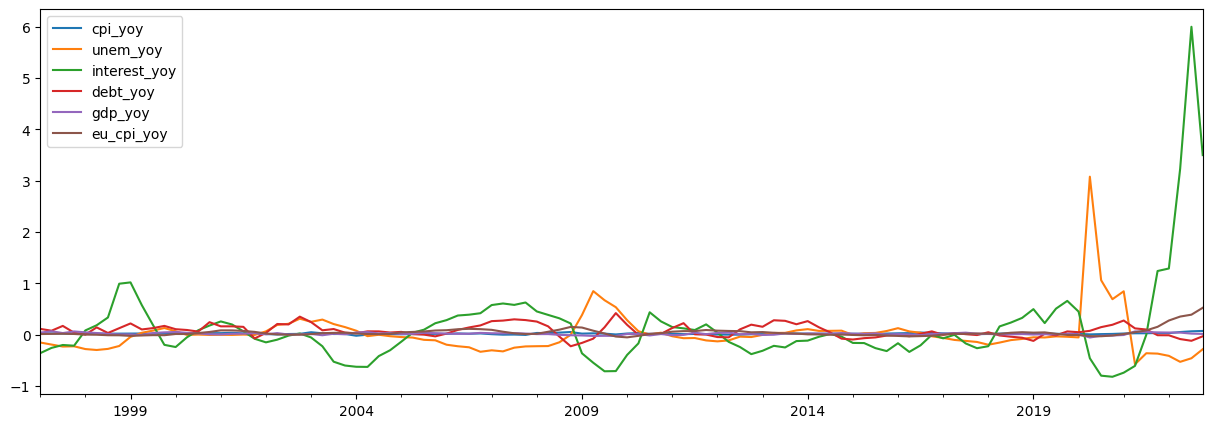

In [34]:
yoy_cols = ['cpi_yoy','unem_yoy', 'interest_yoy', 'debt_yoy', 'gdp_yoy', 'eu_cpi_yoy']
df[yoy_cols].plot(figsize=(15,5))
plt.show()

Wow! dette forstod jeg ikke noe av la oss se vekk i fra hendelsene etter 2020.


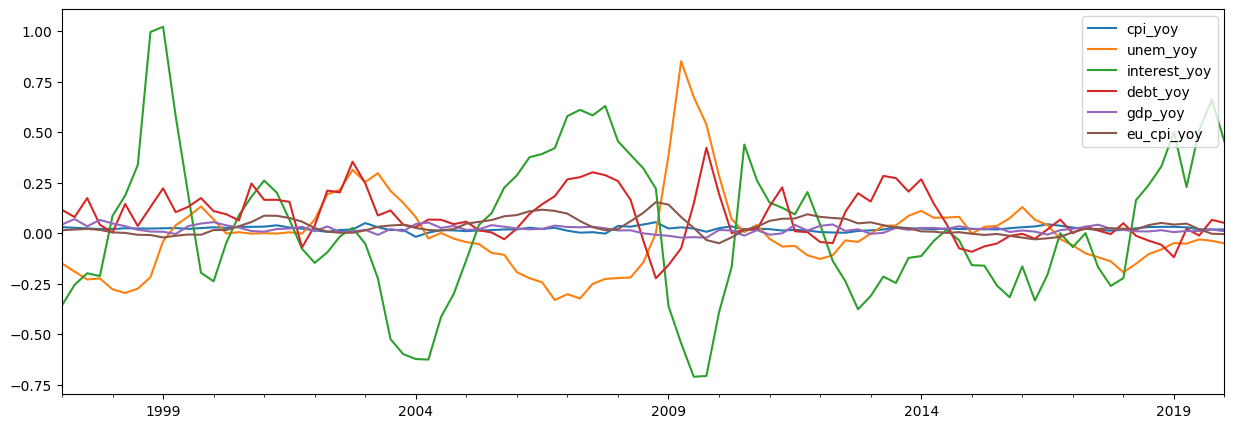

In [35]:
yoy_cols = ['cpi_yoy','unem_yoy', 'interest_yoy', 'debt_yoy', 'gdp_yoy', 'eu_cpi_yoy']
df[yoy_cols].iloc[:-11].plot(figsize=(15,5))
plt.show()

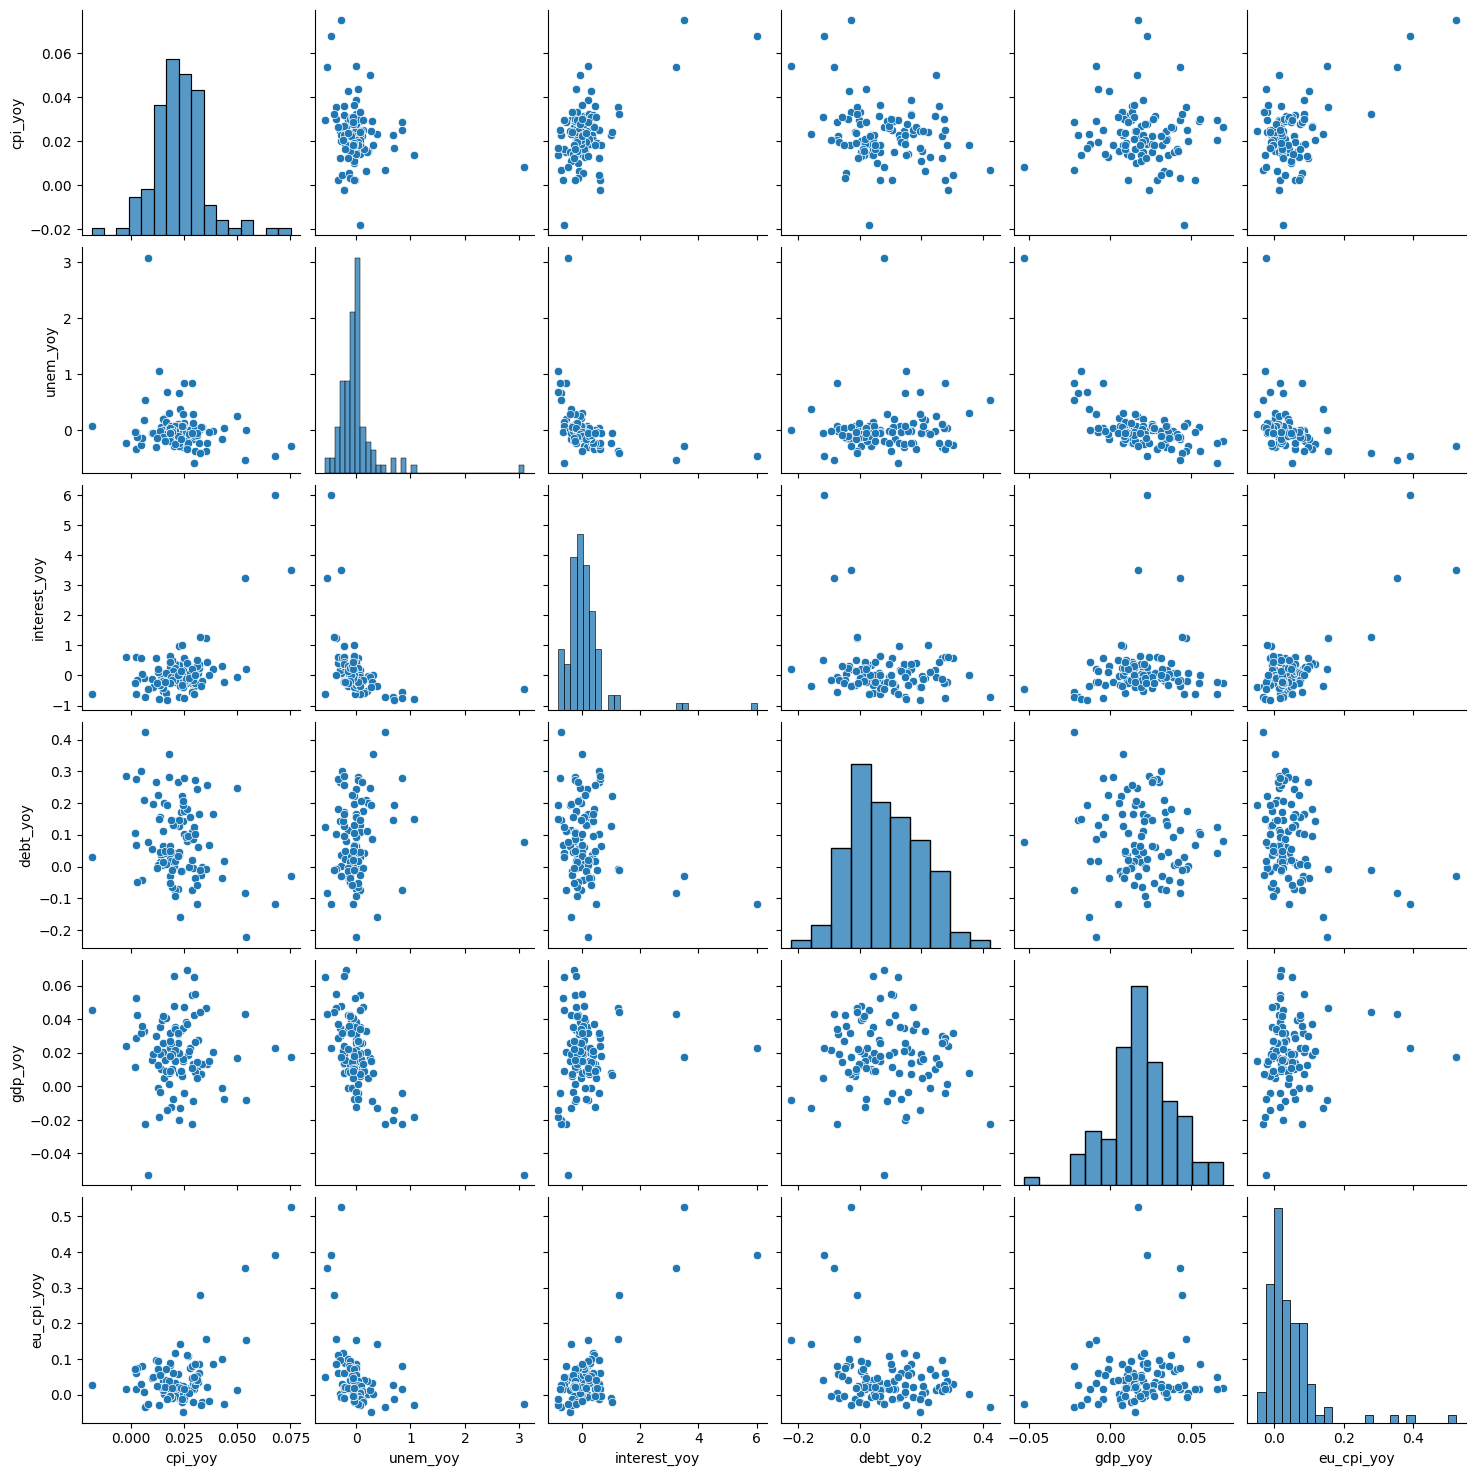

In [10]:
sns.pairplot(df[yoy_cols])
plt.show()

In [36]:
df[yoy_cols].corr().style.background_gradient(cmap='bwr')

,cpi_yoy,unem_yoy,interest_yoy,debt_yoy,gdp_yoy,eu_cpi_yoy
cpi_yoy,1.000000,-0.193983,0.563775,-0.271687,-0.047569,0.534116
unem_yoy,-0.193983,1.000000,-0.380541,0.119628,-0.630972,-0.321998
interest_yoy,0.563775,-0.380541,1.000000,-0.217748,0.115159,0.772727
debt_yoy,-0.271687,0.119628,-0.217748,1.000000,-0.069497,-0.301806
gdp_yoy,-0.047569,-0.630972,0.115159,-0.069497,1.000000,0.137851
eu_cpi_yoy,0.534116,-0.321998,0.772727,-0.301806,0.137851,1.000000


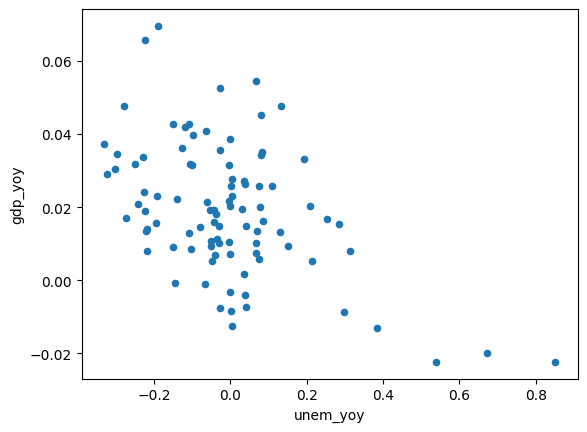

In [37]:
df.iloc[:-11].plot(x='unem_yoy', y='gdp_yoy', kind='scatter' )
plt.show()

In [106]:
import statsmodels.api as sm
X, y = df[['unem_yoy']].iloc[:-11], df['gdp_yoy'].iloc[:-11]
# X, y = df[['unem_yoy']].copy(), df['gdp_yoy'].copy()
X['unem_yoy_2'] = X['unem_yoy']**2

X = sm.add_constant(X)
model1 = sm.OLS(y,X)
results = model1.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                gdp_yoy   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     14.78
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           2.81e-06
Time:                        21:20:57   Log-Likelihood:                 255.18
No. Observations:                  93   AIC:                            -504.4
Df Residuals:                      90   BIC:                            -496.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.002     10.513      0.0

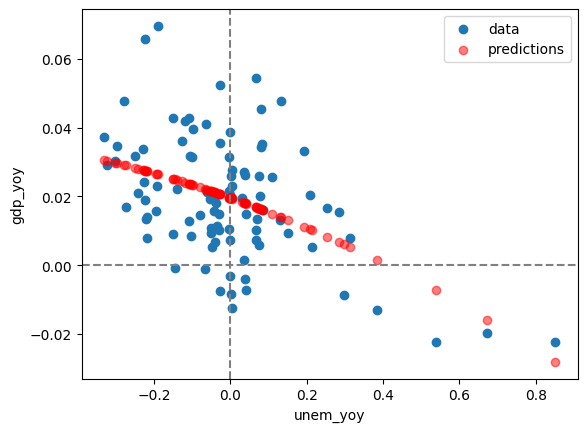

In [126]:
y_pred = results.params[0] + results.params[1]*X['unem_yoy'] + results.params[2]*X['unem_yoy_2']

plt.scatter(X['unem_yoy'],y, label='data')
plt.scatter(X['unem_yoy'], y_pred, c='r', alpha=0.5, label='predictions')
plt.axhline(0, linestyle='--', c='grey')
plt.axvline(0, linestyle='--', c='grey')
plt.xlabel('unem_yoy')
plt.ylabel('gdp_yoy')
plt.legend()
plt.show()

# Yahoo finance

```console
pip install yfinance
```

docs: https://pypi.org/project/yfinance/

Den er ganske nais når den virker. Datakvaliteten fra Yahoo er litt bobb bobb, men man kan være heldig.

In [128]:
import yfinance as yf

In [134]:
msft = yf.Ticker("MSFT")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="10y")

In [136]:
msft.actions

,Dividends,Stock Splits
Date,,
2013-11-19 00:00:00-05:00,0.28,0.0
2014-02-18 00:00:00-05:00,0.28,0.0
2014-05-13 00:00:00-04:00,0.28,0.0
2014-08-19 00:00:00-04:00,0.28,0.0
2014-11-18 00:00:00-05:00,0.31,0.0
2015-02-17 00:00:00-05:00,0.31,0.0
2015-05-19 00:00:00-04:00,0.31,0.0
2015-08-18 00:00:00-04:00,0.31,0.0
2015-11-17 00:00:00-05:00,0.36,0.0


In [138]:
msft.income_stmt

,2023-06-30,2022-06-30,2021-06-30,2020-06-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.189786,0.131134,0.138266,0.16
Normalized EBITDA,102384000000.0,97843000000.0,81602000000.0,65755000000.0
Total Unusual Items,-15000000.0,334000000.0,1303000000.0,28000000.0
Total Unusual Items Excluding Goodwill,-15000000.0,334000000.0,1303000000.0,28000000.0
Net Income From Continuing Operation Net Minority Interest,72361000000.0,72738000000.0,61271000000.0,44281000000.0
Reconciled Depreciation,13861000000.0,14460000000.0,11686000000.0,12796000000.0
Reconciled Cost Of Revenue,65863000000.0,62650000000.0,52232000000.0,46078000000.0
EBITDA,102384000000.0,97843000000.0,81602000000.0,65755000000.0
EBIT,88523000000.0,83383000000.0,69916000000.0,52959000000.0


## Norsk Hydro

In [142]:
nhy = yf.Ticker("NHY.OL")

# get all stock info
nhy.info

{'address1': 'Drammensveien 264',
 'city': 'Oslo',
 'zip': '0283',
 'country': 'Norway',
 'phone': '47 22 53 81 00',
 'website': 'https://www.hydro.com',
 'industry': 'Aluminum',
 'industryDisp': 'Aluminum',
 'sector': 'Basic Materials',
 'sectorDisp': 'Basic Materials',
 'longBusinessSummary': "Norsk Hydro ASA engages in the power production, bauxite extraction, alumina refining, aluminium smelting, remelting, and recycling activities; and provision of extruded solutions worldwide. It operates through Hydro Bauxite & Alumina, Hydro Aluminium Metal, Hydro Metal Markets, Hydro Extrusions, and Hydro Energy segments. The Hydro Bauxite & Alumina segment engages in bauxite mining activities, production of alumina, and related commercial activities, primarily the sale of alumina. The Hydro Aluminium Metal segment is involved in the primary aluminum production casting activities. This segment principally offers extrusion ingots, foundry alloys, and sheet and standard ingots. The Metal Markets

In [143]:
nhy.income_stmt

,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Tax Effect Of Unusual Items,143000000.0,-19440000.0,350070000.0,-169400000.0
Tax Rate For Calcs,0.25,0.24,0.21,0.22
Normalized EBITDA,41982000000.0,27868000000.0,13284000000.0,9857000000.0
Total Unusual Items,572000000.0,-81000000.0,2796000000.0,-770000000.0
Total Unusual Items Excluding Goodwill,572000000.0,-81000000.0,1667000000.0,-770000000.0
Net Income From Continuing Operation Net Minority Interest,24118000000.0,12148000000.0,1845000000.0,-1811000000.0
Reconciled Depreciation,8929000000.0,8281000000.0,12253000000.0,9485000000.0
Reconciled Cost Of Revenue,129373000000.0,96687000000.0,84592000000.0,106046000000.0
EBITDA,42554000000.0,27787000000.0,16080000000.0,9087000000.0
EBIT,33625000000.0,19506000000.0,3827000000.0,-398000000.0


In [144]:
nhy.actions

,Dividends,Stock Splits
Date,,
2000-04-27 00:00:00+02:00,1.473989,0.0
2001-05-03 00:00:00+02:00,1.750362,0.0
2002-05-03 00:00:00+02:00,1.842486,0.0
2003-05-08 00:00:00+02:00,1.934610,0.0
2004-05-12 00:00:00+02:00,2.026734,0.0
2005-05-04 00:00:00+02:00,3.684972,0.0
2006-05-10 00:00:00+02:00,3.734230,5.0
2007-05-09 00:00:00+02:00,4.606215,0.0
2008-05-07 00:00:00+02:00,3.224350,0.0


In [150]:
nhy.quarterly_income_stmt.loc['EBITDA']

2023-06-30     9803000000.0
2023-03-31     4683000000.0
2022-12-31     4706000000.0
2022-09-30    10620000000.0
2022-06-30    16571000000.0
Name: EBITDA, dtype: object

# Titlon

https://titlon.uit.no/

In [140]:
import pandas as pd
#Query script for MySQL client
import pymysql
con = pymysql.connect(host='titlon.uit.no', 
                    user="williavs@ntnu.no", 
                    password="quai5KM@dE6i%4PKQDdBM", 
                    database='OSE')  
crsr=con.cursor()
crsr.execute("""
	SELECT  * FROM `OSE`.`equity` 
	WHERE year(`Date`) >= 1980
	ORDER BY `Name`,`Date`
""")
r=crsr.fetchall()
df=pd.DataFrame(list(r), columns=[i[0] for i in crsr.description])
df



#YOU NEED TO BE CONNECTED TO YOUR INSTITUTION VIA VPN, OR BE AT THE INSTITUTION, FOR THIS CODE TO WORK
#kjøretid er ca. 5 min

,Date,SecurityId,CompanyId,Symbol,ISIN,Name,BestBidPrice,BestAskPrice,Open,High,...,lnDeltaOBX,NOWA_DayLnrate,bills_3month_Lnrate,Sector,IN_OSEBX,Equity,Debt,Earnings,debt_ratio,PE
0,2019-07-12,1304857,12720.0,2020,BMG9156K1018,2020 Bulkers,82.05,83.00,87.20,90.00,...,0.000000,0.000056,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN
1,2019-07-15,1304857,12720.0,2020,BMG9156K1018,2020 Bulkers,80.05,81.00,83.00,83.98,...,-0.001063,0.000055,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN
2,2019-07-16,1304857,12720.0,2020,BMG9156K1018,2020 Bulkers,80.55,81.00,81.00,81.00,...,-0.009158,0.000055,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN
3,2019-07-17,1304857,12720.0,2020,BMG9156K1018,2020 Bulkers,80.40,81.00,81.00,81.00,...,-0.008003,0.000055,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN
4,2019-07-18,1304857,12720.0,2020,BMG9156K1018,2020 Bulkers,77.40,80.00,80.01,80.01,...,-0.005844,0.000056,0.000057,Industrials,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643738,2015-11-02,67098,8383.0,ZONC,NO0010373947,Zoncolan,0.40,0.75,0.62,0.66,...,0.005338,0.000033,0.000031,Financials,0,17594000.0,326000.0,-21567000.0,0.018192,-0.455862
1643739,2015-11-17,67098,8383.0,ZONC,NO0010373947,Zoncolan,0.55,0.60,0.55,0.55,...,0.015343,0.000033,0.000030,Financials,0,17594000.0,326000.0,-21567000.0,0.018192,-0.379885
1643740,2015-11-19,67098,8383.0,ZONC,NO0010373947,Zoncolan,0.50,0.60,0.55,0.63,...,0.000703,0.000034,0.000030,Financials,0,17594000.0,326000.0,-21567000.0,0.018192,-0.435141
1643741,2015-11-20,67098,8383.0,ZONC,NO0010373947,Zoncolan,0.42,0.63,0.63,0.63,...,-0.004561,0.000034,0.000028,Financials,0,17594000.0,326000.0,-21567000.0,0.018192,-0.435141


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643743 entries, 0 to 1643742
Data columns (total 53 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Date                        1643743 non-null  object 
 1   SecurityId                  1643743 non-null  int64  
 2   CompanyId                   1643612 non-null  float64
 3   Symbol                      1643743 non-null  object 
 4   ISIN                        1643743 non-null  object 
 5   Name                        1643743 non-null  object 
 6   BestBidPrice                1630328 non-null  float64
 7   BestAskPrice                1624643 non-null  float64
 8   Open                        1521506 non-null  float64
 9   High                        1643732 non-null  float64
 10  Low                         1643732 non-null  float64
 11  Close                       1643743 non-null  float64
 12  OfficialNumberOfTrades      1643663 non-null  float64
 1

Som dere kan se er dataen noe eldre, men kilden god dersom du skal gjøre trenger høy kvalitet data i store mengder.

In [154]:
df['Date'].max()

datetime.date(2020, 11, 27)